In [1]:
%matplotlib notebook
# %matplotlib notebook doesn't work on vscode

import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi

%reload_ext autoreload
%aimport Funcs
%aimport poisson_solver
from Funcs import u_dir, df1_2, df2_2
from poisson_solver import SOR_solver

In [2]:
"""
import sys
try:
    del sys.modules['Funcs']
except: pass
from Funcs import *
"""

# all units are in SI
N       = 50
M       = 50
Lx      = 0.002  # m
Ly      = 0.002  # m
Lslot   = 0.0005 # m
Lcoflow = 0.0005 # m
dt      = 1e-7   # s
nu      = 15e-6  # m²s⁻¹
#nu      = 10**-3 # m²s⁻¹
rho     = 1.1614 # kg m⁻³
cp      = 1200 # J / kg / K
dx      = Lx/N
dy      = Ly/N
Ns_c    = int(Lslot          /dx) #N for the point between the slot and te coflow
Nc_lw   = int((Lslot+Lcoflow)/dx) #N for the point between the coflow and the rest of the wall

Uslot   = 1  # inlet  speed in m/s
Ucoflow = .2 # coflow speed in m/s 


def set_boundary(u,v):
    
    #left wall (slipping)
    u[0,:] = 0 
    v[0,:] = v[1,:]
    #u[M-1,:] = 0
    #v[M-1,:] = v[M-2,:]
    
    #gas inlets (upper and lower left boundaries)
    u[:Nc_lw, 0] = 0 # flow/2       
    u[:Nc_lw,-1] = 0 #flow/2   
    v[:Ns_c, 0]  =  Uslot
    v[:Ns_c,-1]  = -Uslot
    v[Ns_c:Nc_lw, 0] =  Ucoflow
    v[Ns_c:Nc_lw,-1] = -Ucoflow
    
    # upper and lower right non-slipping walls:
    u[Nc_lw:, 0] = 0 # u[Nc_lw:, 1]       
    v[Nc_lw:, 0] = 0       
    u[Nc_lw:,-1] = 0 # u[Nc_lw:,-2]
    v[Nc_lw:,-1] = 0                

    # right gaz outlet (forced steady-state --> Neumann BC)
    u[M-1,:] = u[M-2,:]
    v[M-1,:] = v[M-2,:]

    return u,v  

In [3]:
%autoreload 1

w = 2 / (1 + sin(pi/N)) # optimal parameter in the symmatrical case NxN

@jit(nopython=True)
def compute_P(u, v, dx, dt, rho, Pprev=None):
    # no need to compute dvdx or dudy
    dudx = df1_2(u, dx, axis=0)
    dvdy = df1_2(v, dx, axis=1)
    b = dx**2 * rho / dt * (dudx + dvdy)
    
    return SOR_solver(b, Pprev=Pprev, w=w, maxit=10000)

In [4]:
# initial setup of velocity field
u = np.zeros((N,M))
v = np.copy(u)
u,v = set_boundary(u,v)

In [5]:
Nt = 1000

Ut = np.zeros((2, Nt, *u.shape)) # pack both velocity components into one array

In [6]:
for n in range(Nt): 
    Ut[0, n] = u
    Ut[1, n] = v
    
    u,v = u_dir(u,v,dx,dy,dt,nu)
    u,v = set_boundary(u,v)
    
    P = compute_P(u, v, dx, dt, rho)
    
    # third step (P)
    dPdx = df1_2(P, dx, axis=0)
    dPdy = df1_2(P, dx, axis=1)
    
    u = u - dt / rho * dPdx
    v = v - dt / rho * dPdy
    
    # apply BCs one more at the end?
    #u,v = set_boundary(u,v)
    

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
uplot, vplot = Ut[0,-1].T, Ut[1,-1].T
#color = np.sqrt(uplot**2 + vplot**2)
ax.quiver(Ut[0,-1].T, Ut[1,-1].T)
ax.set_title('velocity field')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

<IPython.core.display.Javascript object>

Text(0, 0.5, '$y$')

In [8]:
fig, axs=plt.subplots(2,2, figsize=(6,6), sharex=True, sharey=True)
#[ax1,ax2,ax3,ax4] = axs.flatten()

umax = np.max(np.abs(Ut))

for i in [0,1]:
    [ax1, ax2] = axs[i,:]
    
    im1=ax1.imshow(Ut[i, 0].T, cmap='seismic', vmax=umax, vmin=-umax, origin='lower') # first frame
    im2=ax2.imshow(Ut[i,-1].T, cmap='seismic', vmax=umax, vmin=-umax, origin='lower') # last frame
    
    s = '$u$' if i==0 else '$v$'
    fig.colorbar(im1, ax=ax1)
    ax1.set_title("{} at $n=0$".format(s))
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    #im2=ax2.imshow(np.abs(vres[numplot]).T)
    fig.colorbar(im2, ax=ax2)
    ax2.set_title(r"{} at $n=${}".format(s,Nt))
    fig.suptitle(r'velocity fields: $\nu$ = {}, $\Delta t=${}'.format(nu,dt))
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    #fig.set_size_inches(15,5)

    #plt.savefig("img_dt={}_nu={}, flow_rate={}.jpg".format(dt,nu,flow))


<IPython.core.display.Javascript object>

**Maximum strain rate**

what is max($|\frac{\partial v}{\partial y}|$) ?


In [9]:
a = np.abs(df1_2(v, dy, axis=1))
print(np.max(a[0,:]))

1527.728946195199


**species and temperature**

In [10]:
@jit(nopython=True)
def set_CH4_BC(Y_CH4):
    
    # set to Neumann BC first everywhere:
    Y_CH4[0,:]  = Y_CH4[1,:]
    Y_CH4[-1,:] = Y_CH4[-2,:]
    Y_CH4[:,0]  = Y_CH4[:,1]
    Y_CH4[:,-1] = Y_CH4[:,-2]
    
    #taking the gas out of O2 inlets
    Y_CH4[:Ns_c, 0] = 0 
    #taking the gas out of N2 inlets
    for j in [0,-1]:
        Y_CH4[Ns_c:Nc_lw, j] = 0
    # inlet (upper left corner)
    Y_CH4[:Ns_c, -1] = 1    
        
    return Y_CH4

@jit(nopython=True)
def set_O2_BC(Y_O2):
    
    # set to Neumann BC first everywhere:
    Y_O2[0,:]  = Y_O2[1,:]
    Y_O2[-1,:] = Y_O2[-2,:]
    Y_O2[:,0]  = Y_O2[:,1]
    Y_O2[:,-1] = Y_O2[:,-2]
    
    #taking the gas out of CH4 inlets
    Y_O2[:Ns_c, -1] = 0 
    #taking the gas out of N2 inlets
    for j in [0,-1]:
        Y_O2[Ns_c:Nc_lw, j] = 0
    # inlet (lower left corner)
    Y_O2[:Ns_c, 0] = .233   
    
    return Y_O2

@jit(nopython=True)
def set_N2_BC(Y_N2):
    
    # set to Neumann BC first everywhere:
    Y_N2[0,:]  = Y_N2[1,:]
    Y_N2[-1,:] = Y_N2[-2,:]
    Y_N2[:,0]  = Y_N2[:,1]
    Y_N2[:,-1] = Y_N2[:,-2]
        
    #taking the gas out of CH4 inlets
    Y_N2[:Ns_c, -1] = 0 
    # inlet (lower and upper coflow inlets)
    for j in [0,-1]:
        Y_N2[Ns_c:Nc_lw, j] = 1 
    
    Y_N2[:Ns_c, 0] = .767   
    
        
    return Y_N2

@jit(nopython=True)
def set_CO2_BC(Y_CO2):
    
    # set to Neumann BC first everywhere:
    Y_CO2[0,:]  = Y_CO2[1,:]
    Y_CO2[-1,:] = Y_CO2[-2,:]
    Y_CO2[:,0]  = Y_CO2[:,1]
    Y_CO2[:,-1] = Y_CO2[:,-2]   
    #taking the gas out of CH4 inlets
    Y_CO2[:Ns_c, -1] = 0 
    #taking the gas out of O2 inlets
    Y_CO2[:Ns_c, 0] = 0
    #taking the gas out of N2 inlets
    for j in [0,-1]:
        Y_CO2[Ns_c:Nc_lw, j] = 0
         
    return Y_CO2

@jit(nopython=True)
def set_H2O_BC(Y_H2O):
    
    # set to Neumann BC first everywhere:
    Y_H2O[0,:]  = Y_H2O[1,:]
    Y_H2O[-1,:] = Y_H2O[-2,:]
    Y_H2O[:,0]  = Y_H2O[:,1]
    Y_H2O[:,-1] = Y_H2O[:,-2]
    #taking the gas out of CH4 inlets
    Y_H2O[:Ns_c, -1] = 0         
    #taking the gas out of O2 inlets
    Y_H2O[:Ns_c, 0] = 0
    #taking the gas out of N2 inlets
    for j in [0,-1]:
        Y_H2O[Ns_c:Nc_lw, j] = 0

    return Y_H2O

@jit(nopython=True)
def set_Temp_BC(Temp):
    
    # set to Neumann BC first everywhere:
    Temp[0,:]  = Temp[1,:]
    Temp[-1,:] = Temp[-2,:]
    Temp[:,0]  = Temp[:,1]
    Temp[:,-1] = Temp[:,-2]
    
    # inlets (lower and upper slot + coflow)
    for j in [0,-1]:
        Temp[:Nc_lw, j] = 300 # Kelvin 
        
    return Temp

Define the different species

In [11]:
species_names = ['CH$_4$', 'O$_2$', 'N$_2$',  'CO$_2$', 'H$_2$O', 'Temperature']

Nt = 20000

CH4, O2, N2, CO2, H2O, Temp = np.zeros((6,N,M))

# note, if we take the following initial values (air inside the chamber at t0),
# the diffusive zone question (3.2) does not make much sense;
O2[:] = .233
N2[:] = .767
# Temp[:] = 300
BCs = [set_CH4_BC, set_O2_BC, set_N2_BC, set_CO2_BC, set_H2O_BC, set_Temp_BC]


species = np.array([CH4, O2, N2, CO2, H2O, Temp])
species_t = np.zeros((*species.shape, Nt))

for k in range(species.shape[0]):
    species[k] = BCs[k](species[k])
if True: #normalizing
    sum_Y = np.sum(species[:-1],axis=0) 
    for k in range(species.shape[0]-1):
        species[k]/=sum_Y

In [12]:
from Funcs import advance_adv_diff

def evolve_species(species, BCs, kspec='all'):
    
    if kspec=='all':
        kspec = range(species.shape[0])
    
    for n in range(Nt):
        for k in kspec:
            Yk = species[k]
            species_t[k, :,:,n] = Yk
            Yk = advance_adv_diff(Yk, dt, u, v, dx, dy, nu)
            # apply BCs
            Yk = BCs[k](Yk)
            species[k] = Yk
        if True: #normalizing
            sum_Y = np.sum(species[:-1],axis=0) 
            for k in range(species.shape[0]-1):
                species[k]=species[k]/sum_Y
    return species


In [13]:
species = evolve_species(species, BCs, kspec='all')

In [14]:
i = -1  #the frame you want to see
nsp = species.shape[0]
fig, axs =plt.subplots(1,nsp+1, figsize=(10,3),sharex=True, sharey=True)
for k in range(nsp+1):
    if k!=nsp:
        im = axs[k].imshow(species_t[k,:,:,i].T, cmap='seismic', origin='lower') #ith frame
        axs[k].set_title(species_names[k])
        fig.colorbar(im, ax=axs[k], shrink=0.3)
    else:
        im = axs[k].imshow((np.sum(species_t[:-1,:,:,i], axis=0)).T, cmap='rainbow', origin='lower') # ith frame
        axs[k].set_title(r'$\Sigma_i{Y_i}$')
        fig.colorbar(im, ax=axs[k], shrink=0.3)
fig.suptitle('frame i={}: '.format(i)+ r'Species concentration / temperature field /$\Sigma_i{Y_i}$')
plt.tight_layout()


<IPython.core.display.Javascript object>

In [15]:
left_wall_N2 = species_t[2,0,:,-1]
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(left_wall_N2)

<IPython.core.display.Javascript object>

### Combustion

In [20]:
from scipy.constants import N_A ,m_p

species_names = ['CH$_4$', 'O$_2$', 'N$_2$', 'H$_2$O', 'CO$_2$']
CH4, O2, N2, H2O, CO2 = np.zeros((5,N,M))
species = np.array([CH4, O2, N2, H2O])
BCs = [set_CH4_BC, set_O2_BC, set_N2_BC, set_H2O_BC, set_CO2_BC]
species_t = np.zeros((*species.shape, Nt))

nu_stoch = np.array([-1, -2, 0, 2, 1])

# exact molar masses [g/mol]:
mH = 1.0079
mO = 16.000
mC = 12.0107
mN = 14.0067
# W = np.array([16., 32., 28., 18., 44.]) * 1e-3 # kg/mol
# more accurate:
W = np.array([mC + 4*mH, 2*mO, 2*mN, 2*mH+mO, mC+2*mO]) * 1e-3 # kg/mol


#W = np.array([16., 32., 28., 18., 44.]) / N_A * 1e-3
dh0 = np.array([-74.9, 0, 0, -241.818, -393.52]) * 1e3 # J/mol


T0 = np.ones((N,M)) * 300

from numpy import exp

nspec = 5
Y = np.zeros((nspec, N,M))
#n = np.zeros_like((Y))

@jit(nopython=True)
def Y_to_n(Y):
    """Converts mass fraction Y to volumic density n in mol/m⁻³."""
    n = np.zeros_like((Y))
    for k in range(nspec):
        n[k] = Y[k] * rho / W[k]

    return n

@jit(nopython=True)
def get_Q(n_CH4, n_O2, T, TA=1e4):
    """
    Express the densities of CH4 and O2 in m⁻³, Temperature T in Kelvin.
    """
    A = 1.1e8
    return A * n_CH4 * n_O2**2 * exp(- TA / T)

n = Y_to_n(Y)

In the following, a little test is done to check whether the intergation of the $Y_k$ and $T$ differential equations is done correctly. The initial conditions given hereafter should leed (if time step is chosen appropriately) to a rise from $1000$K to $\sim 3500$K.

<IPython.core.display.Javascript object>


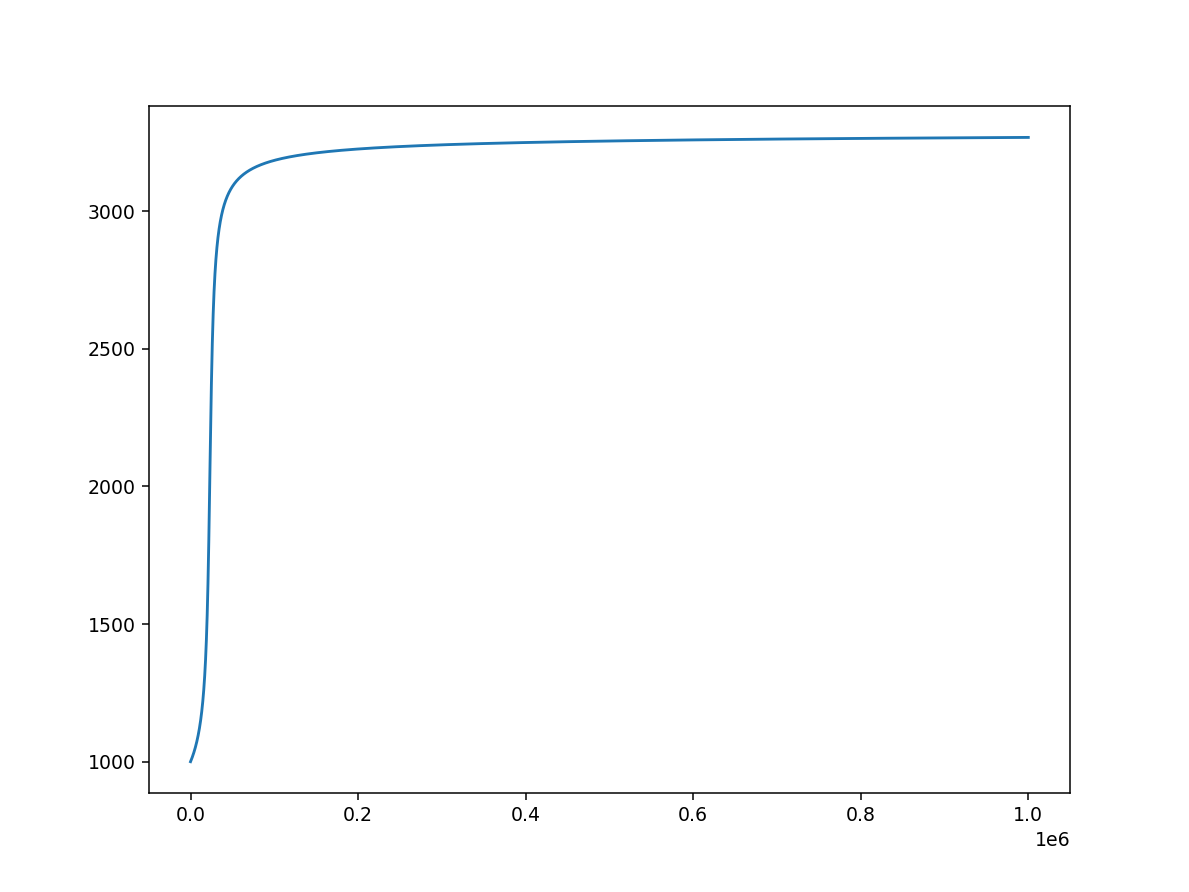

3268.112707455815


In [25]:
#Yk = np.zeros((N,M))
Y_CH4 = 0.055
Y_O2 = 0.233 * (1 - Y_CH4)
Y_N2 = 1 - Y_O2 - Y_CH4
T = 1000
Y_CO2 = 0
Y_H2O = 0

Y = np.array([Y_CH4, Y_O2, Y_N2, Y_H2O, Y_CO2])

@jit(nopython=True)
def integr_Y_chem(Y, T):
    Nt_chem = int(1e6)
    #dt_chem = dt / Nt_chem
    dt_chem = 1e-11
    T_t = np.zeros(Nt_chem)
    for n in range(Nt_chem):        
        T_t[n] = T
        
        n = Y_to_n(Y)
        Q = get_Q(n[0], n[1], T)
        omega_dot = np.zeros(nspec)
        for k in range(nspec):
            omega_dot[k] = W[k] * nu_stoch[k] * Q
            Y[k] += dt_chem * omega_dot[k] / rho
            
        omegaT_dot = - np.sum(dh0 / W * omega_dot)
        T += dt_chem * omegaT_dot / rho / cp
        
    return Y, T_t

Y, T_t = integr_Y_chem(Y, T)

fig, ax = plt.subplots()
ax.plot(T_t)
print(T_t[-1])

Creating a function that takes into account the reaction 
we will impose  a temperature of 1000 in the center of the chamber 

In [18]:
Temp[:] = 300

Th_thick = 0.05*10**-3
Th_band = np.array([Temp.shape[1]/2-Th_thick/dy,
                    Temp.shape[1]/2+Th_thick/dy],dtype=int)

Temp[:,Th_band[0]:Th_band[1]] = 1000
plt.figure()
plt.imshow(Temp.T,cmap="seismic")
plt.title("Temperature distribution in first frame")
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>

as first work we will use the final results from the evolution of species to apply our reaction function and see it's evolution scheme for the given temperature distribution 

In [19]:
import pickle
pickle.dump( np.abs(vres), open( "ures.p", "wb" ) )

NameError: name 'vres' is not defined